# Accessing NYC Connected Vehicle Pilot Data

The goal of this notebook is to provide a basic example of how to access the New York City Connected Vehicle Pilot (CVP) data through the CVP Data Sandbox made available through the USDOT Intelligent Transportation System (ITS) Joint Program Office (JPO)'s Data Program.

**Objective of the notebook**
- Show how to access NYC DOT CV pilot data in the CVP Data Sandbox
- Conduct basic analysis with the data and create basic plots

## Retrieving the Data
<p>NYCDOT CVP data is currently stored in the following folder hierarchy based on when the data is generated:</p>

<p><code>{Source_Name}/{Data_Type}/{Year}/{Month}/{Day}/{Hour}</code></p>
<ul>
  <li><code>{Source_Name}</code>: The data producer of the pilot. Acceptable values: <code>nycdot</code>.</li>
  <li><code>{Data_Type}</code>: The message type of the data. Acceptable values: <code>EVENT</code>.</li>
  <li><code>{Year}</code>: Four-digit year value based on the <code>eventHeader.eventTimeBin</code> field in the record (e.g., <code>2019</code>). Based on NYC (EST/EDT) time zones.</li>
  <li><code>{Month}</code>: Two-digit month value based on the <code>eventHeader.eventTimeBin</code> field in the record (e.g., <code>01</code>). Based on the NYC (EST/EDT) time zones.</li>
  <li><code>{Day}</code>: Day-of-week bin based on the <code>eventHeader.eventTimeBin</code> field in the record, which is based on NYC (EST/EDT) time zones. Acceptable values: <code>MON</code>, <code>TUE</code>, <code>WED</code>, <code>THU</code>, <code>FRI</code>, <code>SAT</code>, <code>SUN</code>, <code>NA</code>.
  <li><code>{Hour}</code>: Time-of-day bin based on the <code>eventHeader.eventTimeBin</code> field in the record, which is based on NYC (EST/EDT) time zones. Acceptable values: <code>AM</code>, <code>PM</code>, <code>MD</code>, <code>EV</code>, <code>NT</code>, <code>NA</code></li>
</ul>

### Load key libraries for the work 
**You will need to install these libraries before running this notebook**
- boto3: AWS python library (http://boto3.readthedocs.io/en/latest/)
- pandas: Python Data Analysis Library (http://pandas.pydata.org)
- seaborn: Python data visualization package for making your graphs pretty (https://seaborn.pydata.org/)

You can install these libraries by running `pip install -r {path_to_sandbox_repo}/example/requirements.txt`

In [1]:
# all imports
import glob
import json
import os
import pprint

import boto3
import pandas as pd
import seaborn as sns

sns.set_theme(style="ticks", color_codes=True, palette='Set2')

BUCKET_NAME ='usdot-its-cvpilot-public-data'

### Create session and client variable for accessing S3

In [2]:
session = boto3.Session(profile_name="awsaml-016250538866-BAHSSO_Admin_Role")
client = session.client('s3')

### List subfolders to determine which day-of-week data was received for April 2021

In [3]:
result = client.list_objects(Bucket=BUCKET_NAME, Delimiter='/', 
                              Prefix='nycdot/EVENT/2021/04/')

print(len(result.get('CommonPrefixes')))

if result.get('CommonPrefixes') is not None:
    for o in result.get('CommonPrefixes'):
        print ('subfolder : ', o.get('Prefix'))
else:
    print('No folder found for that prefix')

8
subfolder :  nycdot/EVENT/2021/04/FRI/
subfolder :  nycdot/EVENT/2021/04/MON/
subfolder :  nycdot/EVENT/2021/04/NA/
subfolder :  nycdot/EVENT/2021/04/SAT/
subfolder :  nycdot/EVENT/2021/04/SUN/
subfolder :  nycdot/EVENT/2021/04/THU/
subfolder :  nycdot/EVENT/2021/04/TUE/
subfolder :  nycdot/EVENT/2021/04/WED/


### List subfolders to determine which time-of-day data was received for April 2021 for the Monday bin

In [4]:
result = client.list_objects(Bucket=BUCKET_NAME, Delimiter='/', 
                              Prefix='nycdot/EVENT/2021/04/MON/')

print(len(result.get('CommonPrefixes')))

if result.get('CommonPrefixes') is not None:
    for o in result.get('CommonPrefixes'):
        print ('subfolder : ', o.get('Prefix'))
else:
    print('No folder found for that prefix')

5
subfolder :  nycdot/EVENT/2021/04/MON/AM/
subfolder :  nycdot/EVENT/2021/04/MON/EV/
subfolder :  nycdot/EVENT/2021/04/MON/MD/
subfolder :  nycdot/EVENT/2021/04/MON/NT/
subfolder :  nycdot/EVENT/2021/04/MON/PM/


### Function for pulling file keys from the AWS S3 bucket

In [5]:
def dir_keys(client, bucket, prefix='', filekeys=[]):
    """
    Lists all file keys from a given prefix in an S3 bucket.  If no prefix is given all file keys are returned

    :param client: S3 connection object
    :param bucket: Name of bucket to search
    :param prefix: Prefix for a given folder
    :param filekeys: list for filekeys
    :return: updated filekey list with added files from search
    """
    paginator = client.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket, Delimiter='/', Prefix=prefix):
        if result.get('Contents') is not None:
            for file in result.get('Contents'):
                if file.get('Key') != 'unknownDataType':
                    filekeys.append(file.get('Key'))
        if result.get('CommonPrefixes') is not None:
            for subdir in result.get('CommonPrefixes'):
                dir_keys(client, bucket, subdir.get('Prefix'), filekeys)
    return filekeys


### Pull all file keys for April 2021 and determine the number of files

In [6]:
filekeys = dir_keys(client, BUCKET_NAME, 'nycdot/EVENT/2021/04/', [])
print('Total number of files:', str(len(filekeys)))

Total number of files: 13544


### Create local directory and download files to do analysis on

In [7]:
# Create local directory
cwd = os.getcwd()
local_directory = cwd + os.sep + 'tmp' + os.sep
if not os.path.exists(local_directory):
    os.makedirs(local_directory)

# Download Files
# for file in filekeys:
#     client.download_file(BUCKET_NAME, file, local_directory + file.split('/')[-1])
print('{} Files loaded to {}'.format(str(len([i for i in os.listdir(local_directory) if i[0] != '.'])), '/tmp/'))

13544 Files loaded to /tmp/


### Look at one of the raw JSON files

In [8]:
# List 3 files downloaded to local directory
! ls {local_directory} | wc -l        # print number of files downloaded
! ls -U {local_directory} | head -3    # print file name of three files downloaded

   13544
bsw_EVT_00e76bb724df8ad3bf249beae37aa7f1664879413eca5bf33b4656067e9b82a0.uper.OBF.txt
bsw_EVT_0211d308dcbd52fb5bc89b79c1037cb242484969a45acded0753c813a6a2d1a0.uper.OBF.txt
bsw_EVT_039c9c9f053af400f051a8bbc02fb49251d8ef162ccc4d38de9e8617d1835a9b.uper.OBF.txt


In [9]:
fp = "./tmp/bsw_EVT_00e76bb724df8ad3bf249beae37aa7f1664879413eca5bf33b4656067e9b82a0.uper.OBF.txt"
with open(fp) as in_f:
    for line in in_f:
        print(line)
        break

{"eventHeader": {"locationSource": "gps", "asdFirmwareVersion": "ASD-SW_v4.3.3.0", "eventAlertActive": false, "eventAlertSent": true, "eventAlertHeard": false, "hostVehID": "BADC13A6", "targetVehID": "94DBA248", "triggerHVSeqNum": 289, "triggerTVSeqNum": 288, "eventType": "bsw", "parameters": {"recordingROI": "300", "timeRecordBefore": "10", "timeRecordFollow": "10", "timeRecordResolution": "resOneTenthOfSec", "minSpdThreshold": "", "timeToCrash": "4"}, "grpId": 21, "eventStatus": "Obfuscated", "eventTimeBin": "2021-04-MON-MD", "eventLocationBin": "N/A", "weatherCondition": "MostlyClear", "airTemperature": 53, "precipitation1Hr": "0.00", "windSpeed": 16, "speedCondition": 48}, "bsmList": [{"eventMsgSeqNum": 1, "bsmRecord": {"msgHeader": {"myRFLevel": 0, "authenticated": true}, "bsmMsg": {"coreData": {"msgCnt": 7, "id": "BADC13A6", "accuracy": {"semiMajor": 5, "semiMinor": 5, "orientation": 0}, "transmission": "forwardGears", "angle": 127, "accelSet": {"long_mpss": 0.19, "lat_mpss": -0.

### Reformat it to make it easier to view

In [10]:
data = json.loads(open(fp).read())
pprint.pprint(data)

{'bsmList': [{'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -9.713,
                                                    'X_m': 3.763,
                                                    'Y_m': -25.967,
                                                    'Z_m': -0.5,
                                                    'accelSet': {'lat_mpss': -0.47000000000000003,
                                                                 'long_mpss': 0.19,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.09},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 

                                                                                                   'xOffset_m': -79.478,
                                                                                                   'yOffset_m': 366.305,
                                                                                                   'zOffset_m': 0.9},
                                                                                                  {'tOffset_s': -6.09,
                                                                                                   'xOffset_m': -78.816,
                                                                                                   'yOffset_m': 419.487,
                                                                                                   'zOffset_m': 1.5},
                                                                                                  {'tOffset_s': -10.4,
                                          

                                                                                                   'yOffset_m': 573.343,
                                                                                                   'zOffset_m': 2.8}]},
                                                                    'pathPrediction': {'confidence': 194,
                                                                                       'radiusOfCurve': -3710}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'vehicleData': {'height': 29}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -90}},
              'eventMsgSeqNum': 12},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -9.313,
                                                    'X_m': 3.601,
                                                    'Y_m': -25.002,
   

                                                                 'long_mpss': 0.01,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.07},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavai

                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 350.488,
                                                    'id': 'BADC13A6',
                                                    'msgCnt': 14,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 2.32,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'lights': {'length': 9,
                                                             

                                                                                                   'yOffset_m': 63.757,
                                                                                                   'zOffset_m': -0.5},
                                                                                                  {'tOffset_s': -14.4,
                                                                                                   'xOffset_m': -61.309,
                                                                                                   'yOffset_m': 101.797,
                                                                                                   'zOffset_m': -2.2},
                                                                                                  {'tOffset_s': -16.3,
                                                                                                   'xOffset_m': -74.353,
                                         

                                                                                                   'yOffset_m': 314.504,
                                                                                                   'zOffset_m': 5.6},
                                                                                                  {'tOffset_s': -123.2,
                                                                                                   'xOffset_m': -81.649,
                                                                                                   'yOffset_m': 353.397,
                                                                                                   'zOffset_m': 6.1}]},
                                                                    'pathPrediction': {'confidence': 197,
                                                                                       'radiusOfCurve': 6705}}},
                                                  {'partII-I

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -8.619,
                                                    'X_m': -2.321,
                                                    'Y_m': 63.916,
                                                    'Z_m': -8.3,
                                                    'accelSet': {'lat_mpss': 0.19,
                                                                 'long_mpss': 0.05,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -0.06},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',


             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -8.413,
                                                    'X_m': 3.276,
                                                    'Y_m': -23.059,
                                                    'Z_m': -0.4,
                                                    'accelSet': {'lat_mpss': -0.43,
                                                                 'long_mpss': -0.06,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.07},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',

                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 19.28,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -2.1,
                                                                                                   'xOffset_m': -74.562,
                                                                                                   'yOffset_m': 319.918,
                                                                                                   'zOffset_m': 0.8},
                                                                                                  {'tOffset_s': -4.6,
                            

                                                                                                   'xOffset_m': -79.478,
                                                                                                   'yOffset_m': 366.305,
                                                                                                   'zOffset_m': 1.5},
                                                                                                  {'tOffset_s': -7.49,
                                                                                                   'xOffset_m': -78.816,
                                                                                                   'yOffset_m': 419.487,
                                                                                                   'zOffset_m': 2.1},
                                                                                                  {'tOffset_s': -11.79,
                                         

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -7.813,
                                                    'X_m': 3.063,
                                                    'Y_m': -21.793,
                                                    'Z_m': -0.4,
                                                    'accelSet': {'lat_mpss': -0.37,
                                                                 'long_mpss': 0.13,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -0.18},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',

                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 350.475,
                                                    'id': 'BADC13A6',
                                                    'msgCnt': 27,
                                                    'size': {'length': 617,
                                    

                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -90.7,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.614,
                                                                                                   'zOffset_m': 1.3},
                                                                                                  {'tOffset_s': -106.3,
                                           

                                                                                                   'zOffset_m': 4.6},
                                                                                                  {'tOffset_s': -121.2,
                                                                                                   'xOffset_m': -77.533,
                                                                                                   'yOffset_m': 314.504,
                                                                                                   'zOffset_m': 5.6}]},
                                                                    'pathPrediction': {'confidence': 191,
                                                                                       'radiusOfCurve': 32767}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 20,
                       

                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 317.4,
                                                    'id': '8DEE97E0',
                                                    'msgCnt': 115,
                                                    'size': {'length': 653,
                                                             'width': 213},
                                                    'speed_mps': 0.0,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -7.5,
                                     

                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -7.6,
                                                                                                   'xOffset_m': -19.818,
                                                                                                   'yOffset_m': 28.115,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -11.69,
                                                                                                   'xOffset_m': -40.283,
                                                                                                   'yOffset_m': 63.757,
          

                                                                                                  {'tOffset_s': -37.59,
                                                                                                   'xOffset_m': -277.514,
                                                                                                   'yOffset_m': 109.869,
                                                                                                   'zOffset_m': -13.1}]},
                                                                    'pathPrediction': {'confidence': 200,
                                                                                       'radiusOfCurve': 32767}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 21,
                                                                    'vehicleData': {'height': 62,
                                        

                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -90}},
              'eventMsgSeqNum': 88},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -6.713,
                                                    'X_m': 2.611,
                                                    'Y_m': -19.229,
                                                    'Z_m': -0.3,
                                                    'accelSet': {'lat_mpss': -0.51,
                                                                 'long_mpss': 0.44,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.07},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'se

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -6.533,
                                                    'X_m': 49.616,
                                                    'Y_m': -175.633,
                                                    'Z_m': -3.5,
                                                    'accelSet': {'lat_mpss': -0.12,
                                                                 'long_mpss': 0.07,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -1.9100000000000001},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs'

                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -8.3,
                                                                                                   'xOffset_m': -19.818,
                                                                                                   'yOffset_m': 28.115,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -12.39,
                                                                                                   'xOffset_m': -40.283,
                                                                                                   'yOffset_m': 63.757,
                                                                                               

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -6.113,
                                                    'X_m': 2.38,
                                                    'Y_m': -17.863,
                                                    'Z_m': -0.3,
                                                    'accelSet': {'lat_mpss': -0.41000000000000003,
                                                                 'long_mpss': 0.4,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.06},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'u

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -6.013,
                                                    'X_m': 2.337,
                                                    'Y_m': -17.63,
                                                    'Z_m': -0.3,
                                                    'accelSet': {'lat_mpss': -0.3,
                                                                 'long_mpss': 0.46,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.06},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
  

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -1.9,
                                                                                                   'xOffset_m': -63.49,
                                                                                                   'yOffset_m': 272.631,
                                                                                                   'zOffset_m': 1.0},
                                                                                                  {'tOffset_s': -4.29,
                                                                                                   'xOffset_m': -74.562,
                                                                                                   'yOffset_m': 319.918,
                                                                                                   'zOffset_m': 2.0},
                                            

                                                                                                   'zOffset_m': 4.0}]},
                                                                    'pathPrediction': {'confidence': 188,
                                                                                       'radiusOfCurve': -4870}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'vehicleData': {'height': 29}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -87}},
              'eventMsgSeqNum': 113},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -5.813,
                                                    'X_m': 2.261,
                                                    'Y_m': -17.153,
                                                    'Z_m': -0.3,
                                                    'accel

                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -8.99,
                                                                                                   'xOffset_m': -19.818,
                                                                                                   'yOffset_m': 28.115,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -13.09,
                                                                                                   'xOffset_m': -40.283,
                                                                                                   'yOffset_m': 63.757,
                                                                                              

                                                                                                  {'tOffset_s': -38.89,
                                                                                                   'xOffset_m': -277.514,
                                                                                                   'yOffset_m': 109.869,
                                                                                                   'zOffset_m': -13.1}]},
                                                                    'pathPrediction': {'confidence': 200,
                                                                                       'radiusOfCurve': 32767}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 21,
                                                                    'vehicleData': {'height': 62,
                                        

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -5.333,
                                                    'X_m': 41.615,
                                                    'Y_m': -154.526,
                                                    'Z_m': -2.9,
                                                    'accelSet': {'lat_mpss': 0.01,
                                                                 'long_mpss': 0.21,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -1.04},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable'

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -5.233,
                                                    'X_m': 40.92,
                                                    'Y_m': -152.784,
                                                    'Z_m': -2.9,
                                                    'accelSet': {'lat_mpss': -0.01,
                                                                 'long_mpss': 0.21,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -0.96},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable'

                                                                                                   'zOffset_m': -2.1},
                                                                                                  {'tOffset_s': -20.2,
                                                                                                   'xOffset_m': -74.353,
                                                                                                   'yOffset_m': 114.821,
                                                                                                   'zOffset_m': -3.2},
                                                                                                  {'tOffset_s': -22.2,
                                                                                                   'xOffset_m': -90.868,
                                                                                                   'yOffset_m': 123.631,
                                        

                                                    'Z_m': -0.2,
                                                    'accelSet': {'lat_mpss': -0.36,
                                                                 'long_mpss': 0.54,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.1},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                   

                                                                                                  {'tOffset_s': -109.2,
                                                                                                   'xOffset_m': -45.258,
                                                                                                   'yOffset_m': 211.665,
                                                                                                   'zOffset_m': 3.2},
                                                                                                  {'tOffset_s': -118.6,
                                                                                                   'xOffset_m': -66.395,
                                                                                                   'yOffset_m': 268.295,
                                                                                                   'zOffset_m': 4.7},
                                        

                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 18.72,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -0.3,
                                                                                                   'xOffset_m': -42.943,
                                                                                                   'yOffset_m': 215.845,
                                                                                                   'zOffset_m': 0.1},
                                                                                                  {'tOffset_s': -3.5,
                            

                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -0.04},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes

                                                    'size': {'length': 653,
                                                             'width': 213},
                                                    'speed_mps': 0.0,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -10.6,
                                                                                                   'xOffset_m': -19.818,
                                                                                                   'yOffset_m': 28.115,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -14.7,
                             

                                                                                                   'xOffset_m': -74.353,
                                                                                                   'yOffset_m': 114.821,
                                                                                                   'zOffset_m': -3.2},
                                                                                                  {'tOffset_s': -23.19,
                                                                                                   'xOffset_m': -90.868,
                                                                                                   'yOffset_m': 123.631,
                                                                                                   'zOffset_m': -4.5},
                                                                                                  {'tOffset_s': -25.3,
                                       

                                                                                                   'zOffset_m': 4.8},
                                                                                                  {'tOffset_s': -124.7,
                                                                                                   'xOffset_m': -77.533,
                                                                                                   'yOffset_m': 314.504,
                                                                                                   'zOffset_m': 5.8}]},
                                                                    'pathPrediction': {'confidence': 180,
                                                                                       'radiusOfCurve': 4167}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 20,
                        

                                                                 'long_mpss': -0.08,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.49},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unava

                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 337.863,
                                                    'id': '94DBA248',
                                                    'msgCnt': 109,
                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 18.48,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -1.19,
                                                                                                   'xOffset_m': -42.943,
                                                                                      

                                                                                                   'yOffset_m': 145.603,
                                                                                                   'zOffset_m': 1.6},
                                                                                                  {'tOffset_s': -110.5,
                                                                                                   'xOffset_m': -45.258,
                                                                                                   'yOffset_m': 211.665,
                                                                                                   'zOffset_m': 3.3},
                                                                                                  {'tOffset_s': -119.9,
                                                                                                   'xOffset_m': -66.395,
                                        

                                                                                                   'zOffset_m': -4.5},
                                                                                                  {'tOffset_s': -26.09,
                                                                                                   'xOffset_m': -111.175,
                                                                                                   'yOffset_m': 127.813,
                                                                                                   'zOffset_m': -5.8},
                                                                                                  {'tOffset_s': -29.89,
                                                                                                   'xOffset_m': -153.473,
                                                                                                   'yOffset_m': 125.88,
                                     

                                                    'accelSet': {'lat_mpss': 0.23,
                                                                 'long_mpss': 1.22,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -0.09},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable'

                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 317.4,
                                                    'id': '8DEE97E0',
                                                    'msgCnt': 30,
                                                    'size': {'length': 653,
                                                             'width': 213},
                                                    'speed_mps': 0.84,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -11.8,
                                                                                                   'xOffset_m': -19.818,
                                                                                          

                                                                                                   'yOffset_m': 95.63,
                                                                                                   'zOffset_m': 0.2},
                                                                                                  {'tOffset_s': -95.5,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.603,
                                                                                                   'zOffset_m': 1.6},
                                                                                                  {'tOffset_s': -111.1,
                                                                                                   'xOffset_m': -45.258,
                                           

                                                                                                   'zOffset_m': 4.8},
                                                                                                  {'tOffset_s': -126.0,
                                                                                                   'xOffset_m': -77.533,
                                                                                                   'yOffset_m': 314.504,
                                                                                                   'zOffset_m': 5.9}]},
                                                                    'pathPrediction': {'confidence': 194,
                                                                                       'radiusOfCurve': 3612}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 20,
                        

                                                                 'long_mpss': -0.12,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.23},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unava

                                                    'heading_deg': 338.975,
                                                    'id': '94DBA248',
                                                    'msgCnt': 122,
                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 18.12,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -2.4,
                                                                                                   'xOffset_m': -42.943,
                                                                                                   'yOffset_m': 215.845,
                                                   

                                                                                                   'zOffset_m': 4.5},
                                                                                                  {'tOffset_s': -13.49,
                                                                                                   'xOffset_m': -78.816,
                                                                                                   'yOffset_m': 419.487,
                                                                                                   'zOffset_m': 5.1}]},
                                                                    'pathPrediction': {'confidence': 155,
                                                                                       'radiusOfCurve': 17459}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'vehicleData': {'height': 29}}}]},
          

                                                   'partII-Value': {'vehicleData': {'height': 29}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -84}},
              'eventMsgSeqNum': 228},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -1.913,
                                                    'X_m': 0.653,
                                                    'Y_m': -5.973,
                                                    'Z_m': -0.1,
                                                    'accelSet': {'lat_mpss': -0.45,
                                                                 'long_mpss': 0.3,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.17},
                                                    'accuracy': {'orientation': 0,
                                               

                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 353.163,
                                                    'id': 'BADC13A6',
                                                    'msgCnt': 87,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 3.04,
                                     

                                                             'width': 198},
                                                    'speed_mps': 3.06,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'lights': {'length': 9,
                                                                               'value': '3000'},
                                                                    'pathHistory': {'crumbData': [{'tOffset_s': -7.1,
                                                                                                   'xOffset_m': -8.889,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.3},
                                    

                                                                                                  {'tOffset_s': -127.2,
                                                                                                   'xOffset_m': -77.533,
                                                                                                   'yOffset_m': 314.504,
                                                                                                   'zOffset_m': 6.0}]},
                                                                    'pathPrediction': {'confidence': 169,
                                                                                       'radiusOfCurve': 2214}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 20,
                                                                    'vehicleData': {'height': 39,
                                            

                                                                                    'mass': 60}}}]},
                            'msgHeader': {'authenticated': True,
                                          'myRFLevel': 0}},
              'eventMsgSeqNum': 247},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -1.314,
                                                    'X_m': -4.867,
                                                    'Y_m': 66.487,
                                                    'Z_m': -8.4,
                                                    'accelSet': {'lat_mpss': 0.23,
                                                                 'long_mpss': 1.31,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': -0.76},
                                                    'accuracy': {'orientation': 0,
                                                  

                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 21,
                                                                    'vehicleData': {'height': 62,
                                                                                    'mass': 34}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -89}},
              'eventMsgSeqNum': 254},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': -1.133,
                                                    'X_m': 14.076,
                                                    'Y_m': -82.994,
                                                    'Z_m': -1.0,
                                                    'accelSet': {'lat_mpss': 0.01,
                                                                 'long_mpss': -0.28,
                                           

                                                                                                   'xOffset_m': -111.175,
                                                                                                   'yOffset_m': 127.813,
                                                                                                   'zOffset_m': -5.9},
                                                                                                  {'tOffset_s': -32.1,
                                                                                                   'xOffset_m': -153.473,
                                                                                                   'yOffset_m': 125.88,
                                                                                                   'zOffset_m': -8.6},
                                                                                                  {'tOffset_s': -43.5,
                                       

                                                                 'yaw_dps': -1.06},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 316.062,


                                                                    'pathHistory': {'crumbData': [{'tOffset_s': -8.0,
                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.4},
                                                                                                  {'tOffset_s': -97.5,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.614,
                                                                                                   'zOffset_m': 1.7},
                                             

                                                                                                   'xOffset_m': -77.533,
                                                                                                   'yOffset_m': 314.504,
                                                                                                   'zOffset_m': 6.0}]},
                                                                    'pathPrediction': {'confidence': 186,
                                                                                       'radiusOfCurve': 2972}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 20,
                                                                    'vehicleData': {'height': 39,
                                                                                    'mass': 60}}}]},
                            'msgHeader': {'authenticated': True

                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -14.3,
                                                                                                   'xOffset_m': -19.818,
                                                                                                   'yOffset_m': 28.104,
                                                                                                   'zOffset_m': -0.1},
                                                                                                  {'tOffset_s': -18.39,
                                                                                                   'xOffset_m': -40.283,
                                                                                                   'yOffset_m': 63.746,
                                                                                             

                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 343.425,
                                                    'id': '94DBA248',
              

                                                    'heading_deg': 343.675,
                                                    'id': '94DBA248',
                                                    'msgCnt': 16,
                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 16.7,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -0.6,
                                                                                                   'xOffset_m': -17.378,
                                                                                                   'yOffset_m': 148.141,
                                                     

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -8.9,
                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.4},
                                                                                                  {'tOffset_s': -98.4,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.614,
                                                                                                   'zOffset_m': 1.7},
                                             

                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -9.0,
                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.4},
                                                                                                  {'tOffset_s': -98.5,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.614,
                                                                                                

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -1.09,
                                                                                                   'xOffset_m': -17.378,
                                                                                                   'yOffset_m': 148.141,
                                                                                                   'zOffset_m': 0.5},
                                                                                                  {'tOffset_s': -5.09,
                                                                                                   'xOffset_m': -42.943,
                                                                                                   'yOffset_m': 215.845,
                                                                                                   'zOffset_m': 2.4},
                                          

                                                                                                  {'tOffset_s': -25.7,
                                                                                                   'xOffset_m': -74.353,
                                                                                                   'yOffset_m': 114.821,
                                                                                                   'zOffset_m': -3.3},
                                                                                                  {'tOffset_s': -27.69,
                                                                                                   'xOffset_m': -90.868,
                                                                                                   'yOffset_m': 123.631,
                                                                                                   'zOffset_m': -4.6},
                                       

                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 345.988,
                                                    'id': '94DBA248',
                                                    'msgCnt': 25,
                                                    'size': {'length': 470,
                                    

                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 16.06,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -1.59,
                                                                                                   'xOffset_m': -17.378,
                                                                                                   'yOffset_m': 148.141,
                                                                                                   'zOffset_m': 0.7},
                                                                                                  {'tOffset_s': -5.59,
                          

                                                                                                  {'tOffset_s': -11.4,
                                                                                                   'xOffset_m': -74.562,
                                                                                                   'yOffset_m': 319.918,
                                                                                                   'zOffset_m': 5.4},
                                                                                                  {'tOffset_s': -13.9,
                                                                                                   'xOffset_m': -79.478,
                                                                                                   'yOffset_m': 366.305,
                                                                                                   'zOffset_m': 6.0}]},
                                        

                                                                                                   'zOffset_m': 6.0}]},
                                                                    'pathPrediction': {'confidence': 189,
                                                                                       'radiusOfCurve': 4105}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'vehicleData': {'height': 29}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -86}},
              'eventMsgSeqNum': 323},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 1.287,
                                                    'X_m': -0.404,
                                                    'Y_m': 3.842,
                                                    'Z_m': 0.1,
                                                    'accelSet'

                                                    'Y_m': 4.486,
                                                    'Z_m': 0.1,
                                                    'accelSet': {'lat_mpss': -0.45,
                                                                 'long_mpss': 0.11,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.48},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                             

                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 354.0,
                                                    'id': 'BADC13A6',
                                                    'msgCnt': 120,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                           

                                                                                                  {'tOffset_s': -28.99,
                                                                                                   'xOffset_m': -90.868,
                                                                                                   'yOffset_m': 123.631,
                                                                                                   'zOffset_m': -4.6},
                                                                                                  {'tOffset_s': -31.1,
                                                                                                   'xOffset_m': -111.175,
                                                                                                   'yOffset_m': 127.813,
                                                                                                   'zOffset_m': -5.9},
                                      

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 1.881,
                                                    'X_m': -15.61,
                                                    'Y_m': 77.539,
                                                    'Z_m': -8.4,
                                                    'accelSet': {'lat_mpss': 0.93,
                                                                 'long_mpss': 0.28,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 5.7},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
   

                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.9100000000000001},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                              

                                                                               'value': '3000'},
                                                                    'pathHistory': {'crumbData': [{'tOffset_s': -11.0,
                                                                                                   'xOffset_m': -8.889,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.5},
                                                                                                  {'tOffset_s': -100.5,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.614,
                                                                

              'eventMsgSeqNum': 358},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 2.587,
                                                    'X_m': -0.825,
                                                    'Y_m': 7.772,
                                                    'Z_m': 0.1,
                                                    'accelSet': {'lat_mpss': -0.39,
                                                                 'long_mpss': -0.06,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.72},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                 

                                                    'accelSet': {'lat_mpss': -0.32,
                                                                 'long_mpss': -0.14,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.54},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable

                                                    'msgCnt': 5,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 2.92,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'lights': {'length': 9,
                                                                               'value': '3000'},
                                                                    'pathHistory': {'crumbData': [{'tOffset_s': -11.59,
                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
           

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -11.7,
                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.5},
                                                                                                  {'tOffset_s': -101.2,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.614,
                                                                                                   'zOffset_m': 1.8},
                                           

                                                                    'pathPrediction': {'confidence': 190,
                                                                                       'radiusOfCurve': 4524}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 20,
                                                                    'vehicleData': {'height': 39,
                                                                                    'mass': 60}}}]},
                            'msgHeader': {'authenticated': True,
                                          'myRFLevel': 0}},
              'eventMsgSeqNum': 377},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 3.181,
                                                    'X_m': -19.387,
                                                    'Y_m': 83.385,
                                                    'Z_m': -8

                            'msgHeader': {'authenticated': True,
                                          'myRFLevel': 0}},
              'eventMsgSeqNum': 380},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 3.267,
                                                    'X_m': -2.293,
                                                    'Y_m': -15.929,
                                                    'Z_m': 0.7,
                                                    'accelSet': {'lat_mpss': -0.04,
                                                                 'long_mpss': -0.67,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.6400000000000001},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                        

                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 336.975,
                                                    'id': '8DEE97E0',
                                                    'msgCnt': 94,
                                                    'size': {'length': 653,
                                    

                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 338.238,
                                                    'id': '8DEE97E0',
                                                    'msgCnt': 95,
                                                    'size': {'length': 653,
                                                             'width': 213},
                                                    'speed_mps': 5.22,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -0.5,
                                                                                                   'xOffset_m': 13.657,


             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 3.767,
                                                    'X_m': -3.301,
                                                    'Y_m': -9.279,
                                                    'Z_m': 0.9,
                                                    'accelSet': {'lat_mpss': -0.1,
                                                                 'long_mpss': -0.61,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.56},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
  

                                                                                                  {'tOffset_s': -31.09,
                                                                                                   'xOffset_m': -90.86,
                                                                                                   'yOffset_m': 123.619,
                                                                                                   'zOffset_m': -4.6},
                                                                                                  {'tOffset_s': -33.2,
                                                                                                   'xOffset_m': -111.175,
                                                                                                   'yOffset_m': 127.813,
                                                                                                   'zOffset_m': -5.9},
                                       

              'eventMsgSeqNum': 405},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 4.067,
                                                    'X_m': -3.849,
                                                    'Y_m': -5.36,
                                                    'Z_m': 1.0,
                                                    'accelSet': {'lat_mpss': 0.01,
                                                                 'long_mpss': -0.55,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.8},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                   

                                                                 'long_mpss': -0.49,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 1.99},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unava

                                                                                                  {'tOffset_s': -102.7,
                                                                                                   'xOffset_m': -20.506,
                                                                                                   'yOffset_m': 145.603,
                                                                                                   'zOffset_m': 1.9},
                                                                                                  {'tOffset_s': -118.3,
                                                                                                   'xOffset_m': -45.258,
                                                                                                   'yOffset_m': 211.665,
                                                                                                   'zOffset_m': 3.6},
                                        

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -2.2,
                                                                                                   'xOffset_m': -5.615,
                                                                                                   'yOffset_m': 101.677,
                                                                                                   'zOffset_m': 0.6},
                                                                                                  {'tOffset_s': -5.2,
                                                                                                   'xOffset_m': -17.378,
                                                                                                   'yOffset_m': 148.141,
                                                                                                   'zOffset_m': 1.8},
                                             

                                                    'msgCnt': 25,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 2.5,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -13.6,
                                                                                                   'xOffset_m': -8.889,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.6},
                                                                                   

                                                             'width': 198},
                                                    'speed_mps': 2.48,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -13.69,
                                                                                                   'xOffset_m': -8.889,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.6},
                                                                                                  {'tOffset_s': -103.19,
                                                                                                   'xO

                                                    'accelSet': {'lat_mpss': -0.01,
                                                                 'long_mpss': -0.32,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 2.12},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 6,
                                                                 'semiMinor': 6},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable

                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -92}},
              'eventMsgSeqNum': 438},
             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 5.387,
                                                    'X_m': -1.506,
                                                    'Y_m': 15.333,
                                                    'Z_m': 0.2,
                                                    'accelSet': {'lat_mpss': -0.3,
                                                                 'long_mpss': -0.04,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.46},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'sem

                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -2.39,
                                                                                                   'xOffset_m': 13.657,
                                                                                                   'yOffset_m': -11.191,
                                                                                                   'zOffset_m': 0.3},
                                                                                                  {'tOffset_s': -5.29,
                                                                                                   'xOffset_m': 3.384,
                                                                                                   'yOffset_m': 1.261,
                                                                                                  

                                                                                                  {'tOffset_s': -16.0,
                                                                                                   'xOffset_m': -74.562,
                                                                                                   'yOffset_m': 319.918,
                                                                                                   'zOffset_m': 6.6}]},
                                                                    'pathPrediction': {'confidence': 193,
                                                                                       'radiusOfCurve': 3783}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'vehicleData': {'height': 29}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -55}},
  

                                                    'msgCnt': 77,
                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 12.0,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -0.1,
                                                                                                   'xOffset_m': 0.576,
                                                                                                   'yOffset_m': 54.482,
                                                                                                   'zOffset_m': 0.0},
                                                                                    

                                                    'heading_deg': 355.788,
                                                    'id': 'BADC13A6',
                                                    'msgCnt': 38,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 2.2,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -14.9,
                                                                                                   'xOffset_m': -8.897,
                                                                                                   'yOffset_m': 95.641,
                                                       

                                                                 'yaw_dps': 0.61},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 356.038,
 

                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 358.163,
                                                    'id': '94DBA248',
                                                    'msgCnt': 82,
                                                    'size': {'length': 470,
                                                             'width': 200},
                                                    'speed_mps': 11.86,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -0.59,
                                                                                                   'xOffset_m': 0.576,
                                                                                         

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 6.781,
                                                    'X_m': -20.975,
                                                    'Y_m': 102.182,
                                                    'Z_m': -8.2,
                                                    'accelSet': {'lat_mpss': 1.35,
                                                                 'long_mpss': 0.89,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 9.88},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',


             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 6.881,
                                                    'X_m': -20.832,
                                                    'Y_m': 102.749,
                                                    'Z_m': -8.2,
                                                    'accelSet': {'lat_mpss': 1.22,
                                                                 'long_mpss': 1.08,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 9.98},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',


                                                                                                   'yOffset_m': 127.813,
                                                                                                   'zOffset_m': -5.7}]},
                                                                    'pathPrediction': {'confidence': 199,
                                                                                       'radiusOfCurve': 313}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 21,
                                                                    'vehicleData': {'height': 62,
                                                                                    'mass': 34}}}]},
                            'msgHeader': {'authenticated': False,
                                          'myRFLevel': -89}},
              'eventMsgSeqNum': 485},
             {'bsm

                                                    'id': '8DEE97E0',
                                                    'msgCnt': 3,
                                                    'size': {'length': 653,
                                                             'width': 213},
                                                    'speed_mps': 6.52,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -1.49,
                                                                                                   'xOffset_m': 16.265,
                                                                                                   'yOffset_m': -24.445,
                                                                                                   'zOffset_m': 0.0},
            

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -1.7,
                                                                                                   'xOffset_m': 16.265,
                                                                                                   'yOffset_m': -24.457,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -4.3,
                                                                                                   'xOffset_m': 13.665,
                                                                                                   'yOffset_m': -11.191,
                                                                                                   'zOffset_m': 0.2},
                                              

                                                                                                   'zOffset_m': 0.2},
                                                                                                  {'tOffset_s': -7.29,
                                                                                                   'xOffset_m': 3.392,
                                                                                                   'yOffset_m': 1.272,
                                                                                                   'zOffset_m': 0.2},
                                                                                                  {'tOffset_s': -22.2,
                                                                                                   'xOffset_m': -19.818,
                                                                                                   'yOffset_m': 28.115,
                                               

                                                                                                   'xOffset_m': -42.943,
                                                                                                   'yOffset_m': 215.845,
                                                                                                   'zOffset_m': 4.2},
                                                                                                  {'tOffset_s': -15.7,
                                                                                                   'xOffset_m': -63.49,
                                                                                                   'yOffset_m': 272.631,
                                                                                                   'zOffset_m': 5.9}]},
                                                                    'pathPrediction': {'confidence': 177,
                                                      

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 7.987,
                                                    'X_m': -1.871,
                                                    'Y_m': 21.24,
                                                    'Z_m': 0.3,
                                                    'accelSet': {'lat_mpss': -0.41000000000000003,
                                                                 'long_mpss': -0.01,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.01},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'u

                                                               'wheelBrakes': '00'},
                                                    'heading_deg': 356.788,
                                                    'id': 'BADC13A6',
                                                    'msgCnt': 59,
                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 2.08,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'lights': {'length': 9,
                                                                               'value': '3000'},
                                                                    'pathHistory': {'crumbData': [{'tOffset_s': -17.0,
                    

                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -2.5,
                                                                                                   'xOffset_m': 0.576,
                                                                                                   'yOffset_m': 54.482,
                                                                                                   'zOffset_m': 0.2},
                                                                                                  {'tOffset_s': -6.1,
                                                                                                   'xOffset_m': -5.615,
                                                                                                   'yOffset_m': 101.677,
                                                                                                   'zOffset_m': 1.2},
                                                

                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 3.18},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 9,
                                                                 'semiMinor': 9},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
                                                               'auxBrakes': 'unavailable',
                                                               'brakeBoost': 'unavailable',
                                                               'scs': 'unavailable',
                                                               'traction': 'unavailable',
                                                               'wheelBrakes'

                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -3.39,
                                                                                                   'xOffset_m': 16.265,
                                                                                                   'yOffset_m': -24.457,
                                                                                                   'zOffset_m': 0.0},
                                                                                                  {'tOffset_s': -5.99,
                                                                                                   'xOffset_m': 13.665,
                                                                                                   'yOffset_m': -11.191,
                                            

                                                                                                   'zOffset_m': -3.0},
                                                                                                  {'tOffset_s': -36.6,
                                                                                                   'xOffset_m': -90.86,
                                                                                                   'yOffset_m': 123.631,
                                                                                                   'zOffset_m': -4.4}]},
                                                                    'pathPrediction': {'confidence': 144,
                                                                                       'radiusOfCurve': 795}}},
                                                  {'partII-Id': 2,
                                                   'partII-Value': {'classification': 21,
                         

             {'bsmRecord': {'bsmMsg': {'coreData': {'T_s': 9.787,
                                                    'X_m': -2.072,
                                                    'Y_m': 24.816,
                                                    'Z_m': 0.3,
                                                    'accelSet': {'lat_mpss': -0.43,
                                                                 'long_mpss': -0.12,
                                                                 'vert_mpss': -0.259,
                                                                 'yaw_dps': 0.39},
                                                    'accuracy': {'orientation': 0,
                                                                 'semiMajor': 5,
                                                                 'semiMinor': 5},
                                                    'angle': 127,
                                                    'brakes': {'abs': 'unavailable',
 

                                                    'size': {'length': 617,
                                                             'width': 198},
                                                    'speed_mps': 1.78,
                                                    'transmission': 'forwardGears'},
                                       'partII': [{'partII-Id': 0,
                                                   'partII-Value': {'pathHistory': {'crumbData': [{'tOffset_s': -18.8,
                                                                                                   'xOffset_m': -8.889,
                                                                                                   'yOffset_m': 95.641,
                                                                                                   'zOffset_m': 0.7},
                                                                                                  {'tOffset_s': -108.3,
                            

### Combine the JSON files into a single JSON file

In [11]:
read_files = glob.glob(local_directory + "*.txt")
with open(local_directory + "merged_file.json", "w") as outfile:
    data = []
    for f in read_files:
        data.append(open(f, "r").read())
    outfile.write("[" + ','.join(data[1:]) + "]")
    
file_json = json.load(open(local_directory + "merged_file.json","r"))

In [12]:
del read_files
del data

### View the event logs in dataframe
*Data is in Event Log format

In [13]:
# see root level fields available for records from April 2021
df = pd.DataFrame(file_json)
print(f'{len(df)} rows')
df.head()

13543 rows


eventHeader  \
0  {'locationSource': 'gpsrsu', 'asdFirmwareVersi...   
1  {'locationSource': 'gps', 'asdFirmwareVersion'...   
2  {'locationSource': 'gps', 'asdFirmwareVersion'...   
3  {'locationSource': 'gps', 'asdFirmwareVersion'...   
4  {'locationSource': 'gps', 'asdFirmwareVersion'...   

                                             bsmList timList  
0  [{'eventMsgSeqNum': 1, 'bsmRecord': {'msgHeade...     NaN  
1  [{'eventMsgSeqNum': 1, 'bsmRecord': {'msgHeade...     NaN  
2  [{'eventMsgSeqNum': 1, 'bsmRecord': {'msgHeade...     NaN  
3  [{'eventMsgSeqNum': 1, 'bsmRecord': {'msgHeade...     NaN  
4  [{'eventMsgSeqNum': 1, 'bsmRecord': {'msgHeade...     NaN

In [14]:
# view event log in dataframe with one event log in each row 
eventHeader_df = pd.json_normalize(df['eventHeader'])
print(f'{len(eventHeader_df)} rows')
eventHeader_df.head()

13543 rows


locationSource asdFirmwareVersion  eventAlertActive  eventAlertSent  \
0         gpsrsu    ASD-SW_v4.3.3.0             False            True   
1            gps    ASD-SW_v4.3.3.0             False            True   
2            gps    ASD-SW_v4.3.3.0             False            True   
3            gps    ASD-SW_v4.3.3.0             False            True   
4            gps    ASD-SW_v4.3.3.0             False            True   

   eventAlertHeard hostVehID targetVehID  triggerHVSeqNum  triggerTVSeqNum  \
0            False  11071D2B    00000000               20            16384   
1            False  E6D4A814    1918CA50              190              189   
2            False  186EAED4    EA14BF63              100              101   
3            False  2C475AC7    00000000               20            16384   
4            False  8C412295    00000000                8            16384   

  eventType  ...  parameters.regulatorySpeed parameters.timeToCrash  \
0   spdcomp  ...                          11                    NaN   
1       bsw  ...                         NaN                      4   
2       ima  ...                         NaN                      0   
3   spdcomp  ...                          11                    NaN   
4   spdcomp  ...                          11                    NaN   

  parameters.excessiveCurveSpd parameters.excessiveCurveSpdTime  \
0                          NaN                              NaN   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                          NaN                              NaN   

  parameters.minCurveSpd  parameters.excessiveZoneSpd  \
0                    NaN                          NaN   
1                    NaN                          NaN   
2                    NaN                          NaN   
3                    NaN                          NaN   
4                    NaN                          NaN   

  parameters.excessiveZoneSpdTime  parameters.postedZoneSpeed  \
0                             NaN                         NaN   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   

   parameters.postedHeightLimit parameters.postedSizeLimit  
0                           NaN                        NaN  
1                           NaN                        NaN  
2                           NaN                        NaN  
3                           NaN                        NaN  
4                           NaN                        NaN  

[5 rows x 36 columns]

In [15]:
# see the sample content of a row
eventHeader_df.iloc[0]

locationSource                               gpsrsu
asdFirmwareVersion                  ASD-SW_v4.3.3.0
eventAlertActive                              False
eventAlertSent                                 True
eventAlertHeard                               False
hostVehID                                  11071D2B
targetVehID                                00000000
triggerHVSeqNum                                  20
triggerTVSeqNum                               16384
eventType                                   spdcomp
grpId                                            23
eventStatus                              Obfuscated
eventTimeBin                         2021-04-WED-NT
eventLocationBin                      CV-MN-1wayAve
weatherCondition                       MostlyCloudy
airTemperature                                   59
precipitation1Hr                               0.00
windSpeed                                         0
speedCondition                                 21.0
parameters.r

### Basic plotting of event type count vs time bin

<AxesSubplot:title={'center':'Number of events in April 2021'}, xlabel='eventType', ylabel='count'>

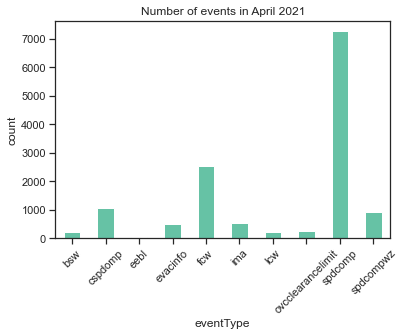

In [16]:
# plot number of events for each event type in the month
eventHeader_df.groupby(['eventType']).size().plot.bar(
    title="Number of events in April 2021", rot=45, ylabel="count")

In [17]:
# modify eventDay and eventTime vars so that they can be ordered by time in graph
eventDayDict = {i: f'{idx} {i}' for idx,i in enumerate('N/A,MON,TUE,WED,THU,FRI,SAT,SUN'.split(','))}
eventTimeDict = {i: f'{idx} {i}' for idx,i in enumerate('N/A,NT,AM,MD,PM,EV'.split(','))}

eventHeader_df['eventDay'] = eventHeader_df['eventTimeBin'].apply(lambda x: x.split('-')[2])
eventHeader_df['eventTime'] = eventHeader_df['eventTimeBin'].apply(lambda x: x.split('-')[3])
eventHeader_df['eventDayTime'] = eventHeader_df['eventTimeBin'].apply(lambda x: "-".join(x.split('-')[2:]))

eventHeader_df['eventDay'] = eventHeader_df['eventDay'].apply(lambda x: eventDayDict[x])
eventHeader_df['eventTime'] = eventHeader_df['eventTime'].apply(lambda x: eventTimeDict[x])

<AxesSubplot:title={'center':'% of events in April 2021 by day-bin'}, xlabel='eventType', ylabel='% in day-bin'>

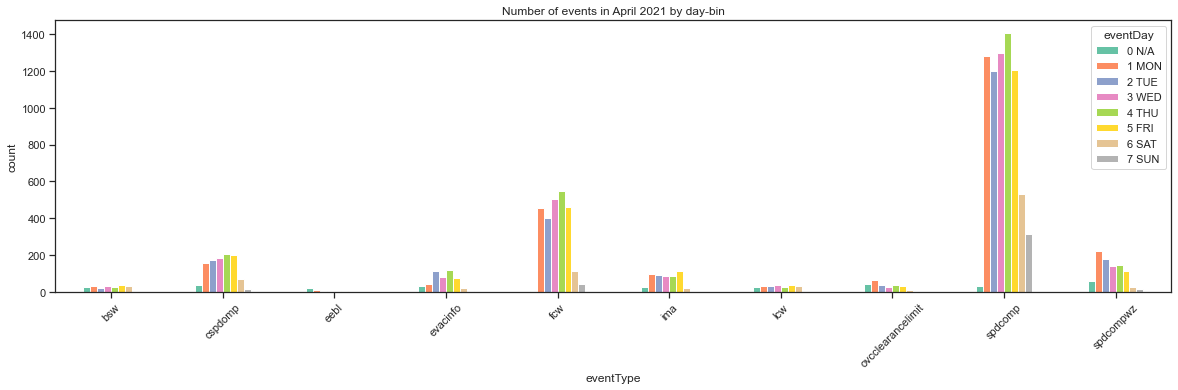

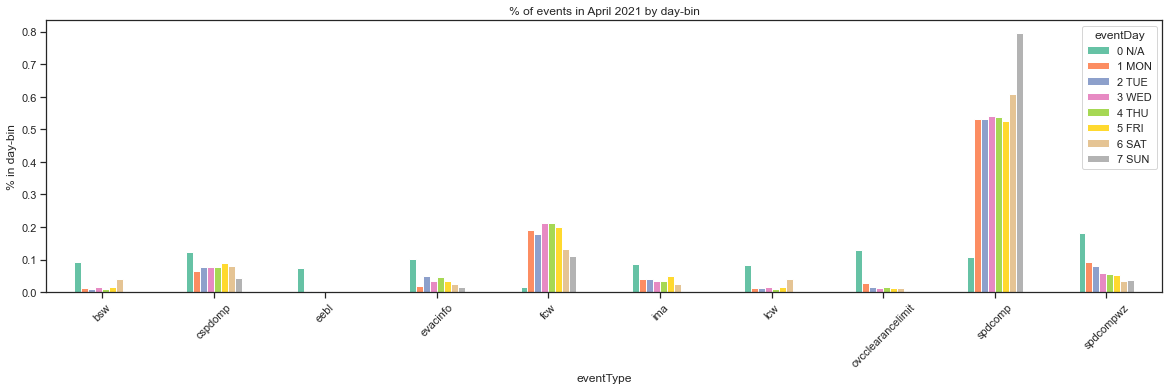

In [18]:
# plot count of event type by day-of-week
# plot % of event type for the time bin by day-of-week

pd.crosstab(eventHeader_df['eventType'], eventHeader_df['eventDay']).plot.bar(
    figsize=(20,5), rot=45, title="Number of events in April 2021 by day-bin", ylabel='count')

day_cross_tab = pd.crosstab(eventHeader_df['eventType'], eventHeader_df['eventDay'])
day_cross_tab_prop = day_cross_tab/day_cross_tab.sum()
day_cross_tab_prop.plot.bar(
    figsize=(20,5), title="% of events in April 2021 by day-bin", ylabel="% in day-bin", rot=45)

<AxesSubplot:title={'center':'% of events in April 2021 by time-bin'}, xlabel='eventType', ylabel='% in time-bin'>

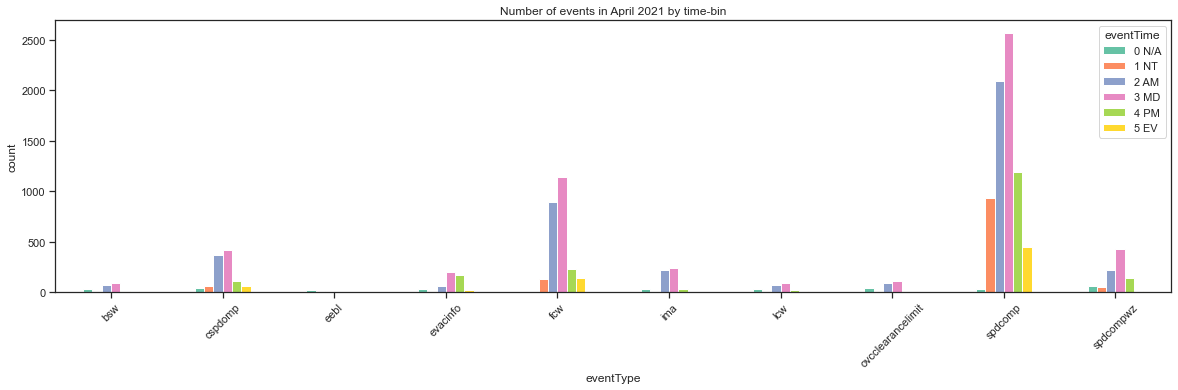

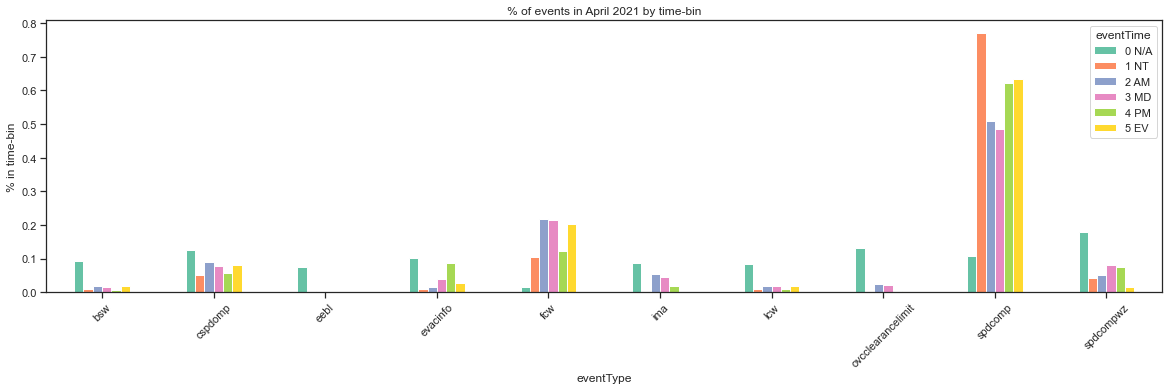

In [19]:
# plot count of event type by time-of-day
# plot % of event type for the time bin by time-of-day

pd.crosstab(eventHeader_df['eventType'], eventHeader_df['eventTime']).plot.bar(
        figsize=(20,5), rot=45, title="Number of events in April 2021 by time-bin", ylabel='count')

time_cross_tab = pd.crosstab(eventHeader_df['eventType'], eventHeader_df['eventTime'])
time_cross_tab_prop = time_cross_tab/time_cross_tab.sum()
time_cross_tab_prop.plot.bar(
    figsize=(20,5), title="% of events in April 2021 by time-bin", ylabel="% in time-bin", rot=45)

### View the BSMs in dataframe

In [20]:
# View the BSMs in a single event log in dataframe

single_event_bsmList_df = pd.json_normalize(file_json[0]['bsmList'])
print(f'{len(single_event_bsmList_df)} rows')
single_event_bsmList_df.head()

29 rows


eventMsgSeqNum  bsmRecord.msgHeader.myRFLevel  \
0               1                              0   
1               2                              0   
2               3                              0   
3               4                              0   
4               5                              0   

   bsmRecord.msgHeader.authenticated  bsmRecord.bsmMsg.coreData.msgCnt  \
0                               True                                 6   
1                               True                                16   
2                               True                                26   
3                               True                                36   
4                               True                                46   

  bsmRecord.bsmMsg.coreData.id  bsmRecord.bsmMsg.coreData.accuracy.semiMajor  \
0                     11071D2B                                            91   
1                     11071D2B                                            80   
2                     11071D2B                                            69   
3                     11071D2B                                            69   
4                     11071D2B                                            71   

   bsmRecord.bsmMsg.coreData.accuracy.semiMinor  \
0                                             1   
1                                             1   
2                                             1   
3                                             1   
4                                             1   

   bsmRecord.bsmMsg.coreData.accuracy.orientation  \
0                                           54678   
1                                           54884   
2                                           55207   
3                                           55362   
4                                           55218   

  bsmRecord.bsmMsg.coreData.transmission  bsmRecord.bsmMsg.coreData.angle  \
0                           forwardGears                              127   
1                           forwardGears                              127   
2                           forwardGears                              127   
3                           forwardGears                              127   
4                           forwardGears                              127   

   ...  bsmRecord.bsmMsg.coreData.brakes.auxBrakes  \
0  ...                                 unavailable   
1  ...                                 unavailable   
2  ...                                 unavailable   
3  ...                                 unavailable   
4  ...                                 unavailable   

   bsmRecord.bsmMsg.coreData.size.width  \
0                                   175   
1                                   175   
2                                   175   
3                                   175   
4                                   175   

   bsmRecord.bsmMsg.coreData.size.length  bsmRecord.bsmMsg.coreData.X_m  \
0                                    470                         92.984   
1                                    470                         88.839   
2                                    470                         84.256   
3                                    470                         79.182   
4                                    470                         74.033   

  bsmRecord.bsmMsg.coreData.Y_m bsmRecord.bsmMsg.coreData.Z_m  \
0                       164.867                           1.0   
1                       156.892                           1.0   
2                       148.684                           1.0   
3                       140.676                           1.0   
4                       132.768                           1.0   

  bsmRecord.bsmMsg.coreData.T_s bsmRecord.bsmMsg.coreData.speed_mps  \
0                       -18.861                                8.82   
1                       -17.861                                9.38   
2                       -16.861     

In [21]:
single_event_bsmList_df.iloc[0]

eventMsgSeqNum                                                                                    1
bsmRecord.msgHeader.myRFLevel                                                                     0
bsmRecord.msgHeader.authenticated                                                              True
bsmRecord.bsmMsg.coreData.msgCnt                                                                  6
bsmRecord.bsmMsg.coreData.id                                                               11071D2B
bsmRecord.bsmMsg.coreData.accuracy.semiMajor                                                     91
bsmRecord.bsmMsg.coreData.accuracy.semiMinor                                                      1
bsmRecord.bsmMsg.coreData.accuracy.orientation                                                54678
bsmRecord.bsmMsg.coreData.transmission                                                 forwardGears
bsmRecord.bsmMsg.coreData.angle                                                                 127


In [23]:
# View event log in dataframe with one bsm record in each row
# Note that we are only doing this on 5 event logs here and already generating 676 rows
# Doing this on all logs from a month at once will take a long time to run and is not advised
df['idx'] = df.index
bsm_df = pd.json_normalize(
    df[['idx', 'bsmList']][:5].to_dict(orient='records'),
    'bsmList', 
    meta=['idx']+[['eventHeader']+i.split('.') for i in eventHeader_df.columns], 
    errors='ignore')

print(f'{len(bsm_df)} rows')
bsm_df.head()

676 rows


eventMsgSeqNum  bsmRecord.msgHeader.myRFLevel  \
0               1                              0   
1               2                              0   
2               3                              0   
3               4                              0   
4               5                              0   

   bsmRecord.msgHeader.authenticated  bsmRecord.bsmMsg.coreData.msgCnt  \
0                               True                                 6   
1                               True                                16   
2                               True                                26   
3                               True                                36   
4                               True                                46   

  bsmRecord.bsmMsg.coreData.id  bsmRecord.bsmMsg.coreData.accuracy.semiMajor  \
0                     11071D2B                                            91   
1                     11071D2B                                            80   
2                     11071D2B                                            69   
3                     11071D2B                                            69   
4                     11071D2B                                            71   

   bsmRecord.bsmMsg.coreData.accuracy.semiMinor  \
0                                             1   
1                                             1   
2                                             1   
3                                             1   
4                                             1   

   bsmRecord.bsmMsg.coreData.accuracy.orientation  \
0                                           54678   
1                                           54884   
2                                           55207   
3                                           55362   
4                                           55218   

  bsmRecord.bsmMsg.coreData.transmission  bsmRecord.bsmMsg.coreData.angle  \
0                           forwardGears                              127   
1                           forwardGears                              127   
2                           forwardGears                              127   
3                           forwardGears                              127   
4                           forwardGears                              127   

   ...  eventHeader.parameters.excessiveCurveSpdTime  \
0  ...                                           NaN   
1  ...                                           NaN   
2  ...                                           NaN   
3  ...                                           NaN   
4  ...                                           NaN   

   eventHeader.parameters.minCurveSpd  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

   eventHeader.parameters.excessiveZoneSpd  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   eventHeader.parameters.excessiveZoneSpdTime  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

  eventHeader.parameters.postedZoneSpeed  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

  eventHeader.parameters.postedHeightLimit  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                 

### Calculate mean speed for each event type for each time bin 

In [24]:
def mean_speed_mps(bsm_list):
    speed_mps = [i['bsmRecord']['bsmMsg']['coreData']['speed_mps'] for i in bsm_list]
    return sum(speed_mps)/len(speed_mps)

In [25]:
mini_df = pd.concat([eventHeader_df[['eventTime', 'eventType']], df['bsmList']], axis=1)
groups = mini_df.groupby(['eventTime', 'eventType'])
mean_speed_df = groups.apply(lambda x: mean_speed_mps(x['bsmList'].sum()))
mean_speed_df

eventTime  eventType        
0 N/A      bsw                  16.856439
           cspdomp              13.601506
           eebl                  8.847038
           evacinfo              7.850030
           fcw                  10.582026
           ima                  11.285032
           lcw                  18.771360
           ovcclearancelimit     4.350575
           spdcomp              11.282672
           spdcompwz             9.933610
1 NT       bsw                  17.966669
           cspdomp              23.524554
           evacinfo              8.857259
           fcw                  10.317571
           lcw                  18.089672
           ovcclearancelimit     4.344851
           spdcomp              10.335433
           spdcompwz             8.780553
2 AM       bsw                  16.811393
           cspdomp              20.307728
           eebl                  9.613786
           evacinfo              4.192614
           fcw                  10.396936
     

<AxesSubplot:title={'center':'Mean Speed by event and time-bin'}, xlabel='eventType', ylabel='mean speed (mps)'>

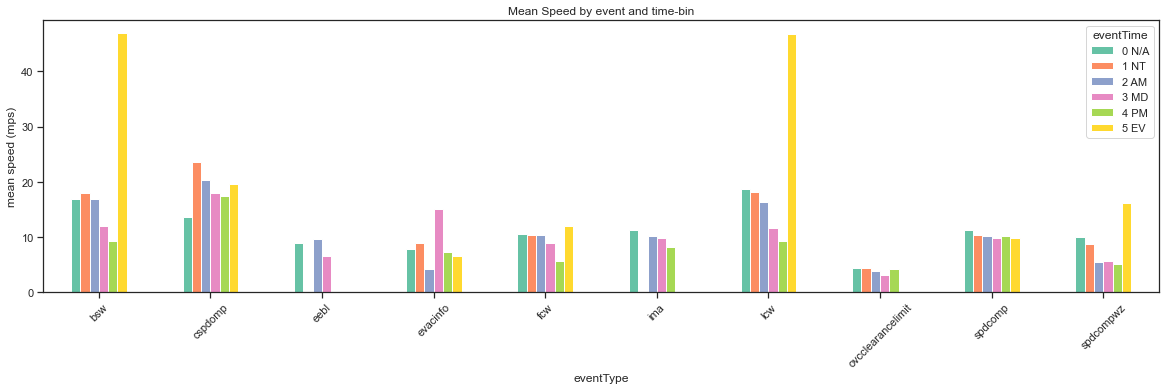

In [26]:
mean_speed_df.reset_index().pivot(index='eventType', columns='eventTime', values=0).plot.bar(
    figsize=(20,5), title="Mean Speed by event and time-bin", ylabel="mean speed (mps)", rot=45)